In [83]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



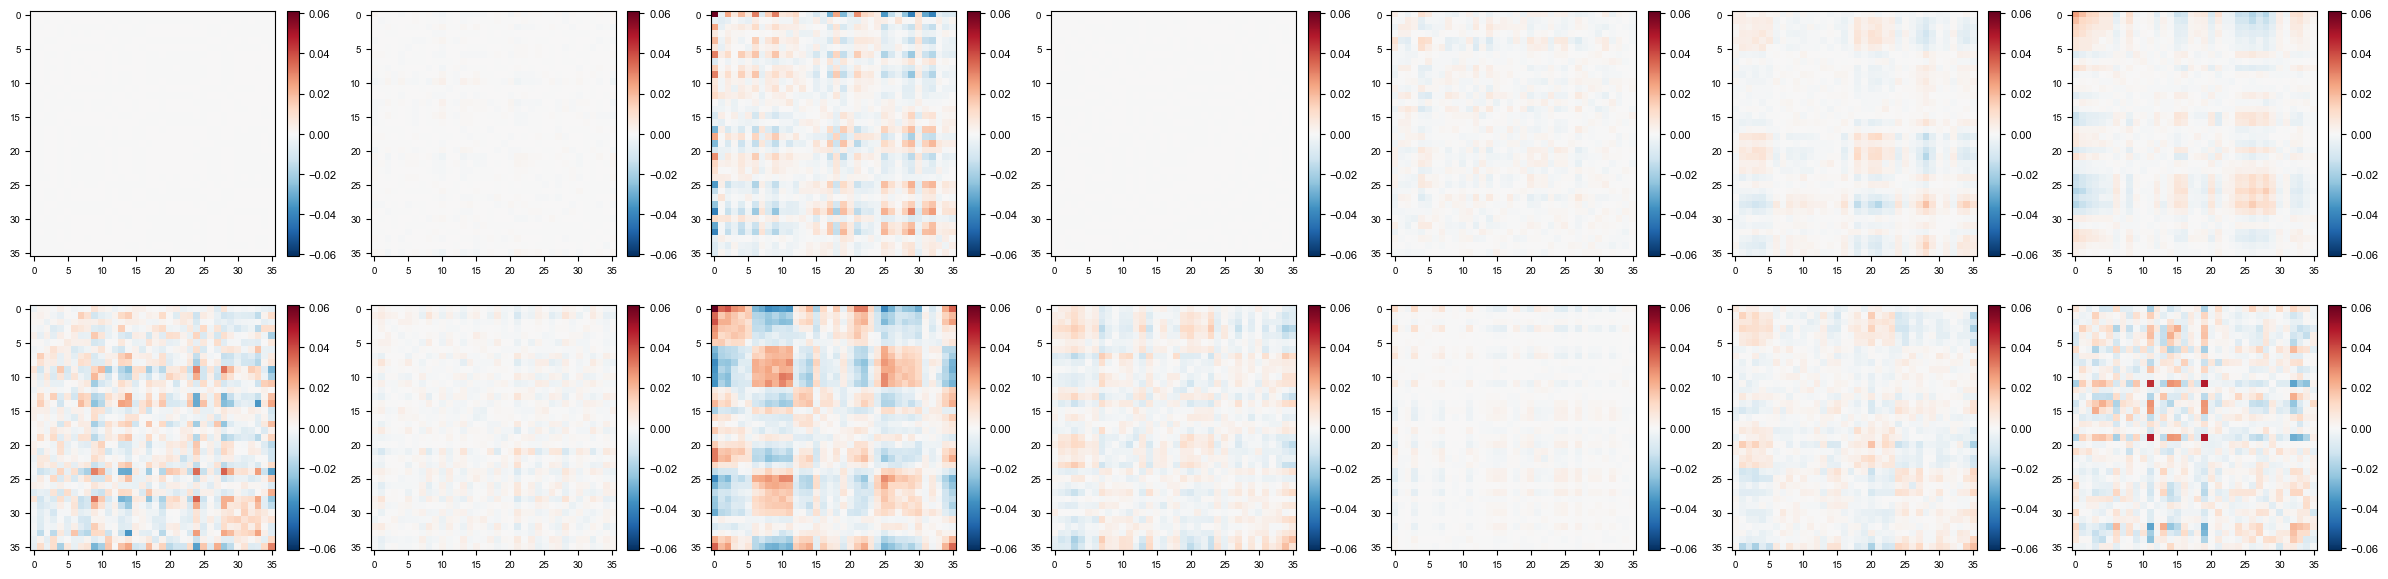

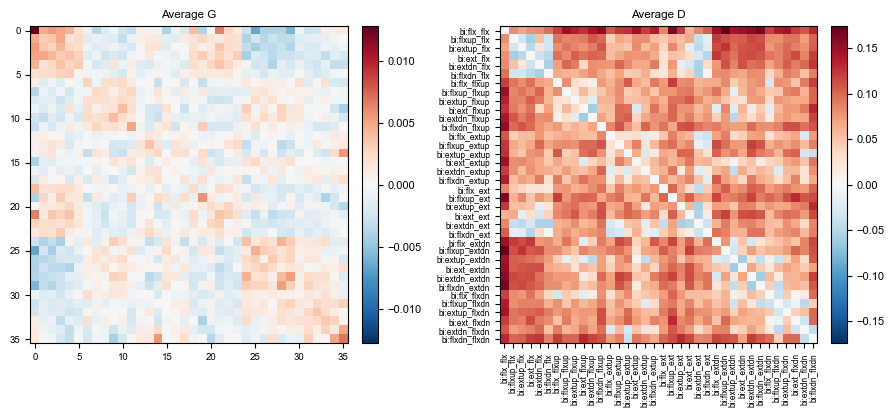

In [95]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

cmap = 'RdBu_r'
sn_bad = []

condition = 'bi'
region = 'M1'
hem = 'R'
regions = [f'{region}_{hem}']

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7

for roi in regions:
    # enumerate hemispheres so we get an integer index for axes
    data, cond_vec, part_vec = [], [], []
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    if '_R' in roi:
        cond_vec_tmp = d['cond_num_vec'][indices]
    elif '_L' in roi:
        cond_vec_tmp = d['cond_num_lhem_bimanual_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        # Filter for the current condition
        idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
        Y = data_tmp[i_sub][idx, :]
        subj_cond = cond_vec_tmp[i_sub][idx]
        subj_part = part_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
        
N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(2*len(regions),7,figsize=(30,7))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(9,4))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].set_xticks(list(range(ncond)))
ax[1].set_yticks(list(range(ncond)))
ax[1].set_yticklabels(labels['L'], fontsize=6)
ax[1].set_xticklabels(labels['L'], rotation=90, fontsize=6)
plt.tight_layout()
plt.show() 



# Models

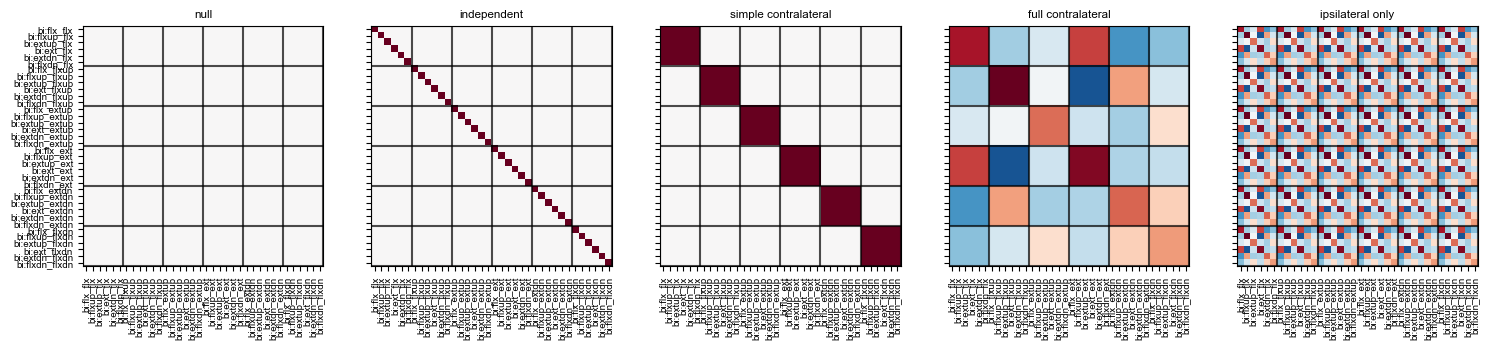

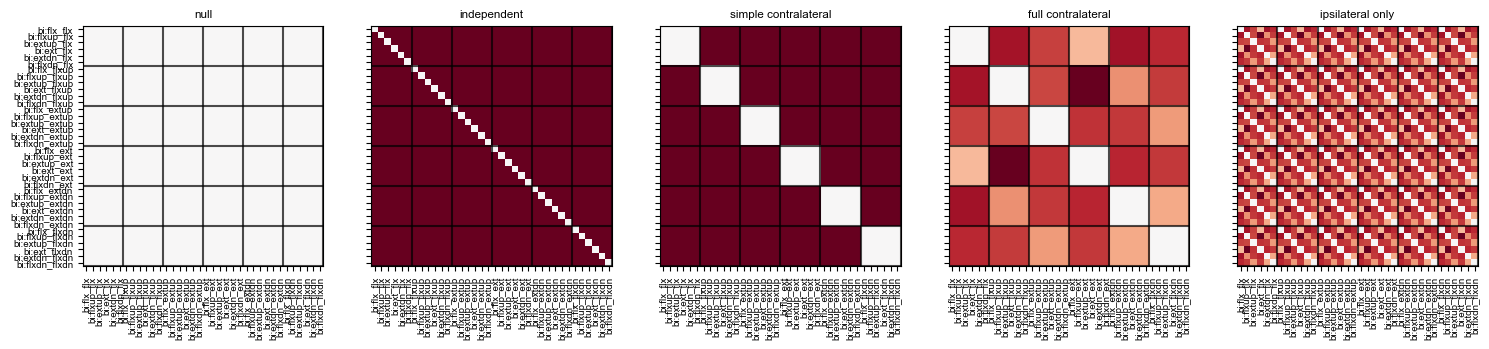

In [94]:
# load unimanual data representations:
uni_contra = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_contra.pkl'))
uni_ipsi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_ipsi.pkl'))
G_uni = uni_contra[uni_contra.region == region].G.values[0]/2 + uni_ipsi[uni_ipsi.region == region].G.values[0]/2

ncond = 36

M = []
modelG = []

# Null model - no information:
cov = np.zeros((ncond, ncond))
M_null = pcm.model.FixedModel('null', cov)
M.append(M_null)

# Independent Hand Model:
cov = np.eye(ncond)
cov = cov/np.trace(cov)
M.append(pcm.model.FixedModel('independent', cov))

# Independent Contralateral Hand Model:
cov = np.eye(6)
cov = np.kron(cov, np.ones((6, 6)))
cov = cov/np.trace(cov)
M.append(pcm.model.FixedModel('simple contralateral', cov))

# Full Contralateral hand model:
cov = np.kron(G_uni, np.ones((6, 6)))
cov = cov/np.trace(cov)
modelG.append(cov)
M.append(pcm.model.FixedModel('full contralateral', cov))

# Ipsilateral only model:
cov = np.tile(G_uni, (6,6))
cov = cov/np.trace(cov)
modelG.append(cov)
M.append(pcm.model.FixedModel('ipsilateral only', cov))

# Full Linear Contra + Ipsi model:
M_full = pcm.ComponentModel('fullcontra+ipsi',[modelG[0],modelG[1]])
M.append(M_full)

# ceiling:
M_ceil = pcm.model.FreeModel('ceil',ncond)
M.append(M_ceil)

# ================== Visualize Models ==================
nmodels = len(M)
fix, ax = plt.subplots(1,nmodels-2, figsize=(18,4), sharey=True)
for i in range(nmodels-2):
    vmin = -np.max(np.abs(M[i].G))-1e-6
    vmax = np.max(np.abs(M[i].G))+1e-6
    ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax)
    block = 6
    bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
    for b in bounds:
        ax[i].axhline(b, color='k', lw=1.5, alpha=0.7)
        ax[i].axvline(b, color='k', lw=1.5, alpha=0.7)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(ncond)))
    ax[i].set_xticklabels(labels[hem], rotation=90)
    ax[i].set_yticks(list(range(ncond)))
    ax[i].set_yticklabels(labels[hem])
    # plt.colorbar(ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,nmodels-2, figsize=(18,4), sharey=True)
for i in range(nmodels-2):
    D = pcm.G_to_dist(M[i].G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D)) - 1e-6
    vmax = np.max(np.abs(D)) + 1e-6
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    block = 6
    bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
    for b in bounds:
        ax[i].axhline(b, color='k', lw=1.5, alpha=0.7)
        ax[i].axvline(b, color='k', lw=1.5, alpha=0.7)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(ncond)))
    ax[i].set_xticklabels(labels[hem], rotation=90)
    ax[i].set_yticks(list(range(ncond)))
    ax[i].set_yticklabels(labels[hem])
    # plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()



# Fit model

In [ ]:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

# save the results:
import pickle
results = {
           'T_gr': T_gr, 'theta_gr': theta_gr,
           'T_cv': T_cv, 'theta_cv': theta_cv
           }
with open(os.path.join(analysisDir, f'PCM_bimanual_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)

fig, ax = plt.subplots(1,1, figsize=(20,3))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])
# ax.set_ylim(-300, 150)
plt.title(f'{region}')
plt.show()



# all together:

Fitting GROUP M1_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV M1_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


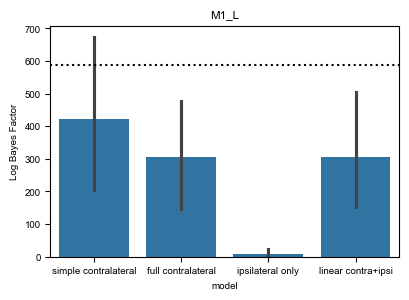

Fitting GROUP M1_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV M1_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


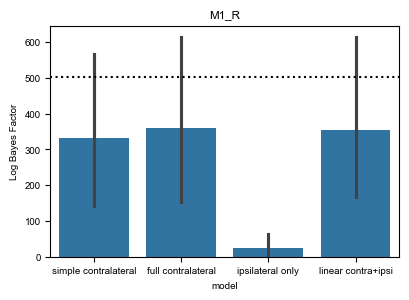

Fitting GROUP S1_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV S1_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


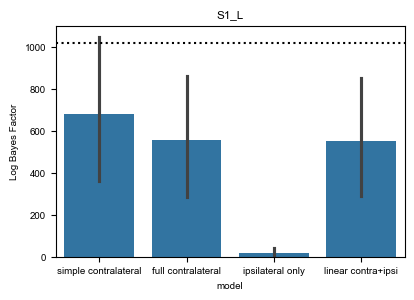

Fitting GROUP S1_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV S1_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


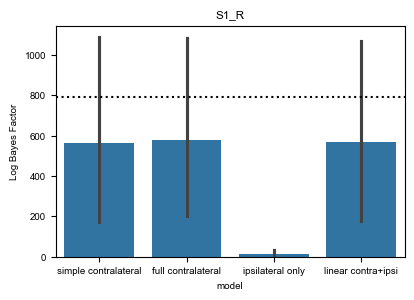

Fitting GROUP PMd_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV PMd_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


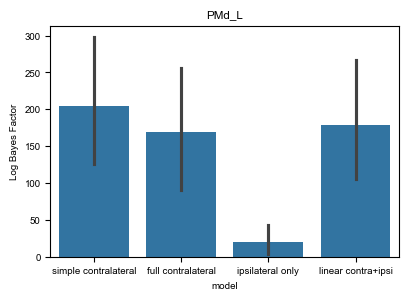

Fitting GROUP PMd_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV PMd_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


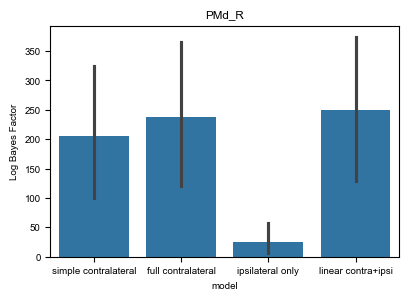

Fitting GROUP PMv_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV PMv_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


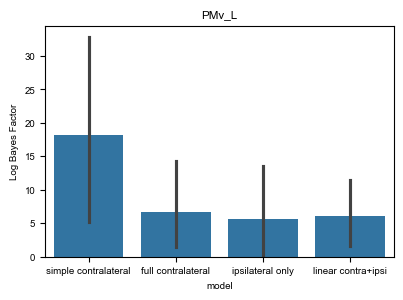

Fitting GROUP PMv_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV PMv_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


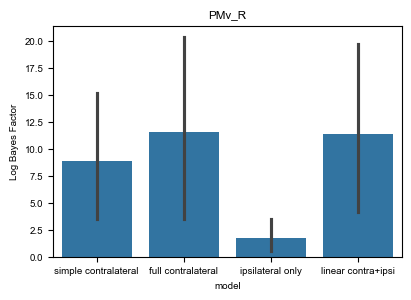

Fitting GROUP SMA_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SMA_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


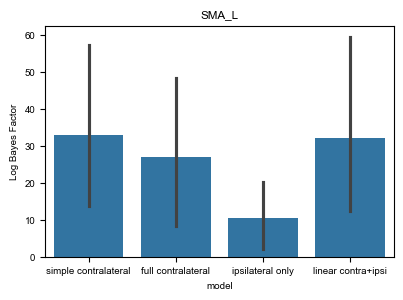

Fitting GROUP SMA_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SMA_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


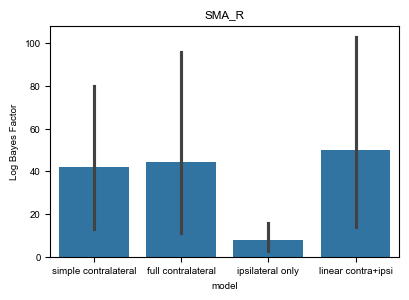

Fitting GROUP SPLa_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SPLa_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


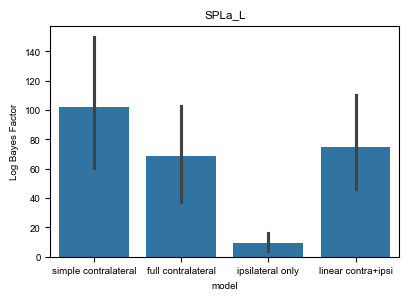

Fitting GROUP SPLa_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SPLa_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


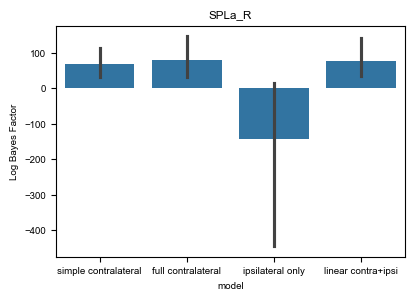

Fitting GROUP SPLp_L ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SPLp_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


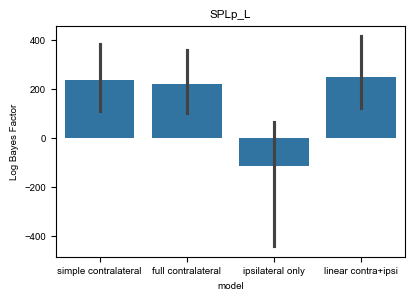

Fitting GROUP SPLp_R ...
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting CV SPLp_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


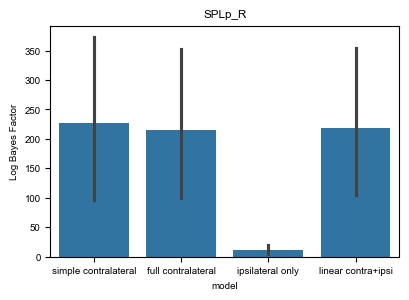

In [ ]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

# load est_g_crossval representations:
uni_contra = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_contra.pkl'))
uni_ipsi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_ipsi.pkl'))
bi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_bi.pkl'))
bi_reg_idx = {'L': 0, 'R': 1}

cmap = 'RdBu_r'
sn_bad = []

name = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp']
for region in name:
    for hem in ['L', 'R']:
        # ======================= MAKE DATASET =======================
        regions = [f'{region}_{hem}']

         # enumerate hemispheres so we get an integer index for axes
        data, cond_vec, part_vec = [], [], []
        for roi in regions:
            file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
            d = np.load(file_path, allow_pickle=True)

            subject = d['subject']
            indices = [k for k, s in enumerate(subject) if s not in sn_bad]

            subject = d['subject'][indices]
            cond_name_tmp = d['cond_intrinsic_vec'][indices]
            if '_R' in roi:
                cond_vec_tmp = d['cond_num_vec'][indices]
            elif '_L' in roi:
                cond_vec_tmp = d['cond_num_lhem_bimanual_vec'][indices]
            data_tmp = d['beta_white'][indices]
            part_tmp = d['part_vec'][indices]

            for i_sub in range(len(subject)):
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

                data.append(Y)
                cond_vec.append(np.array(subj_cond))
                part_vec.append(subj_part)

            Y = []
            for i_sub in range(len(data)):
                obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
                Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
            
        # ================== BUILD Models ==================
        # RDMs from G_est_crossval:
        G_uni = uni_contra[uni_contra.region == region].G.values[0]/2 + uni_ipsi[uni_ipsi.region == region].G.values[0]/2
        G_bi =  bi[bi.region == region].G.values[bi_reg_idx[hem]]
        ncond = 36

        M = []
        modelG = []

        # Null model - no information:
        cov = np.zeros((ncond, ncond))
        M_null = pcm.model.FixedModel('null', cov)
        M.append(M_null)
        
        # Simple Contralateral Hand:
        cov = G_uni * np.eye(6)
        cov = np.kron(cov, np.ones((6, 6)))
        cov = cov/np.trace(cov)
        M.append(pcm.model.FixedModel('simple contralateral', cov))

        # Full Contralateral hand model:
        cov = np.kron(G_uni, np.ones((6, 6)))
        cov = cov/np.trace(cov)
        modelG.append(cov)
        M.append(pcm.model.FixedModel('full contralateral', cov))

        # Ipsilateral only model:
        cov = np.tile(G_uni, (6,6))
        cov = cov/np.trace(cov)
        modelG.append(cov)
        M.append(pcm.model.FixedModel('ipsilateral only', cov))

        # Full Linear Contra + Ipsi model:
        M_full = pcm.ComponentModel('linear contra+ipsi',[modelG[0],modelG[1]])
        M.append(M_full)

        # ceiling:
        # M_ceil = pcm.model.FreeModel('ceil',ncond) # TAKES TOO LONG TO FIT
        M_ceil = pcm.model.FixedModel('ceil', G_bi / np.trace(G_bi))
        M.append(M_ceil)

        # ================== FIT Models ==================
        print(f'Fitting GROUP {region}_{hem} ...')
        T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
        print(f'Fitting CV {region}_{hem} ...')
        T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

        # save the results:
        import pickle
        results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
        with open(os.path.join(analysisDir, f'PCM_bimanual_{region}_{hem}.pkl'), 'wb') as f:
            pickle.dump(results, f)

        fig, ax = plt.subplots(1,1, figsize=(4.5,3))
        ax = pcm.model_plot(T_cv.likelihood,
                                null_model = 'null',
                                noise_ceiling= 'ceil')
        # ax.set_ylim(-300, 150)
        plt.title(f'{region}_{hem}')
        plt.show()




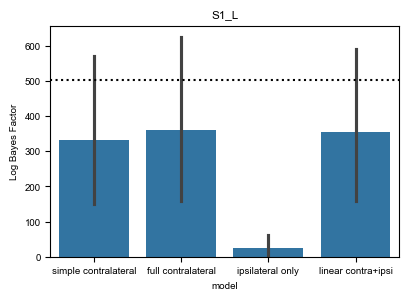

In [80]:
fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil')
# ax.set_ylim(-300, 150)
plt.title(f'{region}_{hem}')
plt.show()

